<a id="top"></a>
# USORT Aperture Generation Notebook

This notebook is used to generate the USORT off-axis and on-axis hexagonal segmented apertures.  


## Package imports

In [ ]:
#%matplotlib qt
import os
os.chdir('../..')
%matplotlib inline
import hcipy
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
import inspect

### Convinence functions

In [2]:
def _unit_vec(angle):
    '''Convenience function to create unit vector at a certain angle.

    Parameters
    ----------
    angle : float
        The angle in radians for the unit vector. A value of zero lays
        along the positive x-axis.

    Returns
    -------
    ndarray
        The unit vector.
    '''
    a = np.cos(angle)
    b = np.sin(angle)

    return np.array([a, b])

## Defining Aperture/LS generation functions

Aperture generation function for the USORT apertures.

In [3]:
def make_usort_pupil_offaxis(normalized=False, 
                             pupil_diameter=7.87,
                             num_rings=2,
                             gap_size=8e-3,
                             segment_point_to_point=1800e-3):
    '''Make the off-axis USORT pupil.

    This pupil is based on priv. comm. with Lee Feinberg (Jul 18, 2023).

    .. note::
        This pupil is parametrized, so you can modify parameters to see
        the influence of your coronagraph as function of gap size and
        other parameters.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    pupil_diameter : scalar
        The circumscribed pupil diameter.
    num_rings : int, optional
        The number of rings of hexagonal segments. The default is 2.
    gap_size : float, optional
        The gap size between the segments in meters. The default is 8e-3 meter.
    segment_point_to_point : float, optional
        The point-to-point size of each of the hexagonal segments in meters.
        The default is 1.8 meters.

    Returns
    -------
    hcipy.Field generator
        A function that takes an hcipy.Grid and evaluates the pupil on this grid.
    '''
    
    segment_flat_to_flat = segment_point_to_point * np.sqrt(3) / 2
    
    if normalized:
        segment_point_to_point /= pupil_diameter
        segment_flat_to_flat /= pupil_diameter
        gap_size /= pupil_diameter
        pupil_diameter = 1.0

    aperture = hcipy.make_hexagonal_segmented_aperture(num_rings, segment_flat_to_flat, gap_size)

    return aperture


def make_usort_pupil_onaxis(normalized=False, 
                            pupil_diameter=7.87,
                            num_rings=2,
                            gap_size=8e-3,
                            segment_point_to_point=1800e-3,
                            obscuration_diameter=787.1e-3,
                            bottom_struts_width=100.7e-3,
                            bottom_struts_connection_width=151.9e-3,
                            bottom_struts_connection_length=589.7e-3,
                            bottom_struts_angle=60,
                            top_strut_width=101.6e-3,
                            top_strut_connection_width=194.8e-3,
                            top_strut_connection_length=505.3e-3):
    '''Make the on-axis USORT pupil.

    This pupil is based on priv. comm. with Lee Feinberg (Jul 18, 2023).

    .. note::
        This pupil is parametrized, so you can modify parameters to see
        the influence of your coronagraph as function of gap size, strut
        widths and other parameters.

    .. warning::
        This pupil is a slightly simplified version of the actual USORT pupil,
        missing the joint in the top support strut and a small overextension
        on the top strut at the bottom of the central obscuration. This pupil
        is for experimentation only and is not the final USORT pupil.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    pupil_diameter : scalar
        The circumscribed pupil diameter.
    num_rings : int, optional
        The number of rings of hexagonal segments. The default is 2.
    gap_size : float, optional
        The gap size between the segments in meters. The default is 8e-3 meter.
    segment_point_to_point : float, optional
        The point-to-point size of each of the hexagonal segments in meters.
        The default is 1.8 meters.
    obscuration_diameter : float, optional
        The diameter of the central obscuration in meters. The default is
        787.1e-3 meter.
    bottom_struts_width : float, optional
        The width of the bottom struts in meters. The default is 100.7e-3
        meter.
    bottom_struts_connection_width : float, optional
        The width of the connection of the bottom struts to the central obscuration
        in meters. The default is 151.9e-3 meter.
    bottom_struts_connection_length : float, optional
        The length of the connection of the bottom struts to the origin, in meters.
        The default is 589.7e-3 meters.
    bottom_struts_angle : float, optional
        The angle between the bottom struts in degrees. The default is 60 degrees.
    top_strut_width : float, optional
        The width of the bottom struts in meters. The default is 101.6e-3
        meter.
    top_strut_connection_width : float, optional
        The width of the connection of the bottom struts to the central obscuration
        in meters. The default is 194.8e-3 meter.
    top_strut_connection_length : float, optional
        The length of the connection of the bottom struts to the origin, in meters.
        The default is 505.3e-3 meters.

    Returns
    -------
    hcipy.Field generator
        A function that takes an hcipy.Grid and evaluates the pupil on this grid.
    '''
    
    offaxis_pupil = make_usort_pupil_offaxis(normalized, pupil_diameter, num_rings, gap_size, segment_point_to_point)
    
    if normalized: 
        obscuration_diameter /= pupil_diameter
        bottom_struts_width /= pupil_diameter
        bottom_struts_connection_width /= pupil_diameter
        bottom_struts_connection_length /= pupil_diameter
        top_strut_width /= pupil_diameter
        top_strut_connection_width /= pupil_diameter
        top_strut_connection_length /= pupil_diameter
        pupil_diameter = 1.0

    obscuration = hcipy.make_circular_aperture(obscuration_diameter)

    bottom_strut_left_angle = -90 + bottom_struts_angle / 2
    bottom_strut_right_angle = -90 - bottom_struts_angle / 2

    bottom_strut_left = hcipy.make_spider_infinite((0, 0), bottom_strut_left_angle, bottom_struts_width)
    bottom_strut_right = hcipy.make_spider_infinite((0, 0), bottom_strut_right_angle, bottom_struts_width)

    bottom_strut_connection_left_point = _unit_vec(np.radians(bottom_strut_left_angle)) * bottom_struts_connection_length
    bottom_strut_connection_left = hcipy.make_spider((0, 0), bottom_strut_connection_left_point, bottom_struts_connection_width)

    bottom_strut_connection_right_point = _unit_vec(np.radians(bottom_strut_right_angle)) * bottom_struts_connection_length
    bottom_strut_connection_right = hcipy.make_spider((0, 0), bottom_strut_connection_right_point, bottom_struts_connection_width)

    top_strut = hcipy.make_spider_infinite((0, 0), 90, top_strut_width)

    top_strut_connection = hcipy.make_spider((0, 0), (0, top_strut_connection_length), top_strut_connection_width)

    def aperture(grid):
        # Combine all parts onto the offaxis pupil.
        ap = offaxis_pupil(grid)

        ap *= 1 - obscuration(grid)

        ap *= bottom_strut_left(grid)
        ap *= bottom_strut_connection_left(grid)

        ap *= bottom_strut_right(grid)
        ap *= bottom_strut_connection_right(grid)

        ap *= top_strut(grid)
        ap *= top_strut_connection(grid)

        return ap

    return aperture


def make_usort_pupil(num_pix, extent=8, normalized=False, offaxis=True, supersampling=16, **kwargs):
    '''Make a USORT pupil with a specified sampling.

    Parameters
    ----------
    num_pix : int
        The number of pixels across in the evaluated pupil. Typical values are 256, 512 or 1024.
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    extent : float
        The spatial extent of the sampling in meters. The final pixel size will be `extent`
        divided by `num_pix`.
    offaxis : bool, optional
        Whether to use the off-axis or on-axis variant of the USORT pupil. By default,
        the off-axis variant is used.
    supersampling : int, optional
        The number of pixels by which to supersample the pupil. With the default of 16,
        the pupil will be evaluated at a 16x higher resolution, then downsampled to the
        requested sampling.
    **kwargs : dict
        Any keyword arguments are passed to the underlying pupil implementation. This is
        either :func:`make_usort_pupil_offaxis` or :func:`make_usort_pupil_onaxis`,
        depending on the value of `offaxis`.

    Returns
    -------
    ndarray
        The evaluated USORT pupil.
    '''
    if offaxis:
        aperture = make_usort_pupil_offaxis(normalized, **kwargs)
    else:
        aperture = make_usort_pupil_onaxis(normalized, **kwargs)
        
    if normalized:
        extent = 1

    pupil_grid = hcipy.make_pupil_grid(num_pix, extent)    
    aperture = hcipy.evaluate_supersampled(aperture, pupil_grid, supersampling)

    return aperture

Function to generate the USORT hexagonal and circular Lyot stop designs.

In [4]:
def make_usort_lyot_stop_circ(normalized=False,
                              pupil_diameter=7.87, 
                              pupil_inscribed = 6.513,
                              inner_diameter_fraction=0.2, 
                              outer_diameter_fraction=0.9):
    '''Make a Lyot stop for the USORT APLC coronagraph.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    pupil_diameter : scalar
        The circumscribed pupil diameter.
    pupil_inscribed : scalar
        The inscribed pupil diameter.
    inner_diameter_fraction : scalar
        The fractional size of the lyot stop inner diameter(s) as a fraction of the inscribed circle diameter.
    outer_diameter_fraction : scalar
        The fractional size of the lyot stop outer diameter(s) as a fraction of the inscribed circle diameter.
    
    Returns
    -------
    lyot_stop : Field generator
        A field generator for the Lyot stop.
    '''
    outer_D = pupil_inscribed * outer_diameter_fraction
    inner_D = pupil_inscribed * inner_diameter_fraction
    
    if normalized:
        outer_D /= pupil_diameter
        inner_D /= pupil_diameter
        pupil_diameter = 1.0
        
    outer_diameter = hcipy.make_circular_aperture(outer_D)
    central_obscuration = hcipy.make_circular_aperture(inner_D)

    def ls(grid):
        result = outer_diameter(grid) - central_obscuration(grid)

        return result

    return ls


def make_usort_lyot_stop_hex(normalized=False,
                             pupil_diameter= 7.87, 
                             pupil_inscribed = 6.513,
                             inner_diameter_fraction=0.2, 
                             outer_diameter_fraction=0.9):
    '''Make a Lyot stop for the USORT APLC coronagraph.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    pupil_diameter : scalar
        The circumscribed pupil diameter.
    pupil_inscribed : scalar
        The inscribed pupil diameter.
    inner_diameter_fraction : scalar
        The fractional size of the lyot stop inner diameter(s) as a fraction of the inscribed circle diameter.
    outer_diameter_fraction : scalar
        The fractional size of the lyot stop outer diameter(s) as a fraction of the inscribed circle diameter.
    
    Returns
    -------
    lyot_stop : Field generator
        A field generator for the Lyot stop.
    '''
    outer_D = pupil_inscribed * outer_diameter_fraction
    inner_D = pupil_inscribed * inner_diameter_fraction
            
    hex_circumdiameter = np.sqrt(2*np.pi / (3 * np.sqrt(3))) * outer_D
    
    if normalized:
        outer_D /= pupil_diameter
        inner_D /= pupil_diameter
        hex_circumdiameter /= pupil_diameter
        pupil_diameter = 1.0
        
    outer_diameter = hcipy.make_hexagonal_aperture(hex_circumdiameter)
    central_obscuration = hcipy.make_hexagonal_aperture(inner_D)

    def ls(grid):
        result = outer_diameter(grid) - central_obscuration(grid)

        return result

    return ls


def make_usort_lyot_stop(num_pix, extent=8, normalized=False, circular=True, supersampling=16, **kwargs):
    '''Make a USORT pupil with a specified sampling.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    num_pix : int
        The number of pixels across in the evaluated pupil. Typical values are 256, 512 or 1024.
    extent : float
        The spatial extent of the sampling in meters. The final pixel size will be `extent`
        divided by `num_pix`.
    circular : bool, optional
        Whether to use the circular or hexagonal variant of the USORT Lyot stop. By default,
        the circular variant is used.
    supersampling : int, optional
        The number of pixels by which to supersample the pupil. With the default of 16,
        the pupil will be evaluated at a 16x higher resolution, then downsampled to the
        requested sampling.
    **kwargs : dict
        Any keyword arguments are passed to the underlying pupil implementation. This is
        either :func:`make_usort_lyot_stop_circ` or :func:`make_usort_lyot_stop_hex`,
        depending on the value of `circular`.

    Returns
    -------
    ndarray
        The evaluated USORT pupil.
    '''
    if circular:
        lyot_stop = make_usort_lyot_stop_circ(normalized, inner_diameter_fraction=ls_id, outer_diameter_fraction=ls_od, **kwargs)
    else:
        lyot_stop = make_usort_lyot_stop_hex(normalized, inner_diameter_fraction=ls_id, outer_diameter_fraction=ls_od,**kwargs)

    if normalized:
        extent = 1.0
    
    pupil_grid = hcipy.make_pupil_grid(num_pix, extent)
    lyot_stop = hcipy.evaluate_supersampled(lyot_stop, pupil_grid, supersampling)

    return lyot_stop

# Setting Parameters
<a id='params'></a>

In [5]:
filepath = 'masks/USORT/'
N        = 128  # Number of pixels in aperture, lyot stop, apodizer array
oversamp = 16   # Oversampling factor in evaluate_supersampled [hcipy/field/util.py]. 
                # If set to 1 returns bw pupil. For gray set to > 1, nominally set to 4 (4 grey levels)
gap_padding = 1 # Gap padding factor

In [6]:
# oversampling factor, black and white or grey pixels:
if oversamp == 1:
    edge = 'bw'
elif oversamp > 1:
    edge = 'gy'

Circumscribed and inscribed pupil diameters as provided by E. Por. 

In [7]:
pupil_diameter = 7.87  # meters
pupil_inscribed = 6.513  # meters

The spacial extent of the sampling. The final pixel size will be `extent` divided by `N`.

In [8]:
extent = pupil_diameter # meters

## Aperture parameters
Segmented pupil composed of hexagonal segments distributed over `num_rings` rings around the central
segment. 

In [9]:
num_rings = 2                     # Number of rings of hexagons N around the central segment
gap_size = 8e-3                   # Gap size between the segments in meters. 
segment_point_to_point = 1800e-3  # Point-to-point size of each of the hexagonal segments in meters.

For the on-axis design:

In [10]:
obscuration_diameter=787.1e-3             # Diameter of the central obscuration in meters. 
bottom_struts_width=100.7e-3              # Width of the bottom struts in meters.
bottom_struts_connection_width=151.9e-3   # Width of the connection of the bottom struts to the central obscuration, in meters.
bottom_struts_connection_length=589.7e-3  # Length of the connection of the bottom struts to the origin, in meters.
bottom_struts_angle=60                    # Angle between the bottom struts in degrees.
top_strut_width=101.6e-3                  # Width of the bottom struts in meters.
top_strut_connection_width=194.8e-3       # Width of the connection of the bottom struts to the central obscuration, in meters.
top_strut_connection_length=505.3e-3      # Length of the connection of the bottom struts to the origin, in meters.

## Lyot Stop parameters

The Lyot stop inner diameter is set to 0 to remove central obstruction.

In [11]:
ls_id = 0.0   # Lyot stop inner diameter, relative to inscribed circle, re-normalized against circumscribed pupil in LS gen function.
ls_od = 0.99  # Lyot stop outer diameter, relative to inscribed circle, re-normalized against circumscribed pupil in LS gen function.

The circumdiameter of the hexagonal lyot stop, calcualted from the outer diameter of the circular lyot stop, such that the two Lyot stops have equivalent area:

In [12]:
circ_outer_D = pupil_inscribed * ls_id                            # Outer diameter of circular lyot stop.
hex_circumdiameter = np.sqrt(2*np.pi/(3*np.sqrt(3)))*circ_outer_D # Circumdiameter of hexagonal lyot stop.

# Construct pupil, write to fits

In [13]:
def make_baseline_pupils(path, normalized=False, overwrite=False):
    '''Compute a full set of baseline pupils and save them to disk.

    Parameters
    ----------
    path : Path-like
        Where to save the computed baseline pupils.
    
    '''
    circumscribed_diameter = 7.87  # meter
    inscribed_diameter = 6.513  # meter

    for num_pix in [N]:
        for off_axis in [True, False]:
            pupil = make_usort_pupil(num_pix, normalized, circumscribed_diameter, off_axis)

            fname = f'TelAp_USORT_{"offaxis" if off_axis else "onaxis"}_ovsamp{oversamp:02d}_N{num_pix:04d}.fits'
            fname = os.path.join(path, fname)
            print(fname)

            header = fits.Header()

            # Include all pupil parameters in the header.
            pup_func = make_usort_pupil_offaxis if off_axis else make_usort_pupil_onaxis
            params = inspect.signature(pup_func).parameters
            for key, param in params.items():
                short_key = ''.join(k[0] for k in key.split('_')).upper()
                header[short_key] = (param.default, key)

            # Include WCS information in the header.
            w = wcs.WCS(naxis=pupil.grid.ndim)
            w.wcs.crpix = np.ones(pupil.grid.ndim)
            w.wcs.cdelt = pupil.grid.delta
            w.wcs.crval = pupil.grid.zero
            w.wcs.ctype = ['X', 'Y']

            header.update(w.to_header())

            # Include telescope name in the header.
            header['TELESCOP'] = ('USORT')
            
            # Include pupil diameter information in the header.
            header['D_CIRC'] = (circumscribed_diameter, 'pupil circumscribed diameter [m]')
            header['D_INSC'] = (inscribed_diameter, 'pupil inscribed diameter [m]')

            # Include on- vs off-axis information.
            header['OFFAXIS'] = (off_axis, 'whether the pupil is off-axis')
            
            # Include oversampling information in the header.
            header['OVERSAMP'] = (oversamp, 'oversampling factor, # grey levels')
            header['EDGE'] = (edge, 'black and white, or grey pixels')

            fits.writeto(fname, pupil.shaped, header, overwrite=overwrite)

In [14]:
filepath = 'masks/USORT/'

make_baseline_pupils(filepath, overwrite=True)

masks/USORT/TelAp_USORT_offaxis_ovsamp16_N0128.fits
masks/USORT/TelAp_USORT_onaxis_ovsamp16_N0128.fits


## Construct lyot stop(s), write to fits

Using knowledge of inscribed circle diameter, we can calculate the pupil diameter prior to corner segment clipping that is needed for the Lyot stop generation.

In [15]:
def make_baseline_lyot_stops(path, normalized=False, overwrite=False):
    '''Compute a full set of baseline Lyot stops and save them to disk.

    Parameters
    ----------
    path : Path-like
        Where to save the computed baseline pupils.
    '''
    circumscribed_diameter = 7.87  # meter
    inscribed_diameter = 6.513  # meter

    for num_pix in [N]:
        for circular in [True, False]:
            lyot_stop = make_usort_lyot_stop(num_pix, circumscribed_diameter, normalized, circular)

            fname = f'LS_USORT_{"circ" if circular else "hex"}_ID{int(ls_id*1000):04d}_OD{int(ls_od*1000):04d}_ovsamp{oversamp}_N{num_pix:04d}.fits'
            fname = os.path.join(path, fname)
            print(fname)

            header = fits.Header()

            # Include all pupil parameters in the header.
            ls_func = make_usort_lyot_stop_circ if circular else make_usort_lyot_stop_hex
            params = inspect.signature(ls_func).parameters
            for key, param in params.items():
                short_key = ''.join(k[0] for k in key.split('_')).upper()
                header[short_key] = (param.default, key)

            # Include WCS information in the header.
            w = wcs.WCS(naxis=lyot_stop.grid.ndim)
            w.wcs.crpix = np.ones(lyot_stop.grid.ndim)
            w.wcs.cdelt = lyot_stop.grid.delta
            w.wcs.crval = lyot_stop.grid.zero
            w.wcs.ctype = ['X', 'Y']

            header.update(w.to_header())

            # Include telescope name in the header.
            header['TELESCOP'] = ('USORT')

            # Include oversampling information in the header.
            header['OVERSAMP'] = (oversamp, 'oversampling factor, # grey levels')
            header['EDGE'] = (edge, 'black and white, or grey pixels')

            # Include circular vs hexagonal information.
            header['CIRCULAR'] = (circular, 'whether the Lyot stop is circular')
            
            if not circular:
                # Include circumdiameter of the hexagonal lyot stop
                header['HEXCIRCD'] = (hex_circumdiameter, 'hexagon circumdiameter')

            fits.writeto(fname, lyot_stop.shaped, header, overwrite=overwrite)

In [16]:
filepath = 'masks/USORT/'

make_baseline_lyot_stops(filepath, overwrite=True)

masks/USORT/LS_USORT_circ_ID0000_OD0990_ovsamp16_N0128.fits
masks/USORT/LS_USORT_hex_ID0000_OD0990_ovsamp16_N0128.fits


# Plot resulting Aperture and Lyot stop

In [17]:
pupil_grid = hcipy.make_pupil_grid(N, pupil_diameter)
pupil_onaxis = make_usort_pupil(N, pupil_diameter, offaxis=False)
pupil_offaxis = make_usort_pupil(N, pupil_diameter)
lyot_stop_circ = make_usort_lyot_stop(N, pupil_diameter)
lyot_stop_hex = make_usort_lyot_stop(N, pupil_diameter, circular=False)

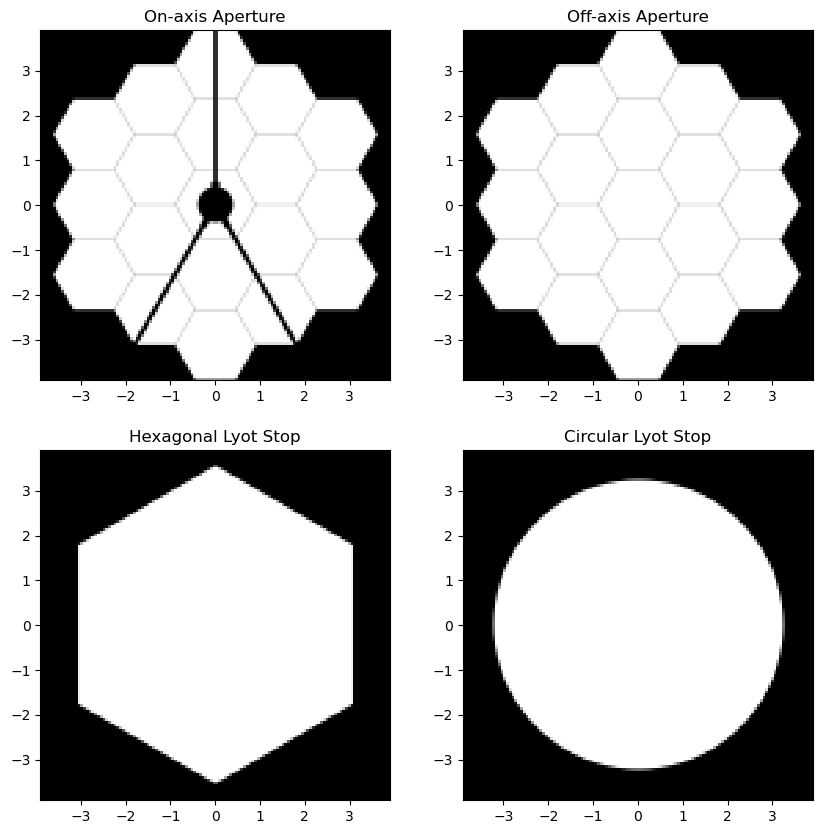

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('On-axis Aperture')
hcipy.imshow_field(pupil_onaxis, cmap='gray')
#plt.axis('off')
plt.subplot(2,2,2)
plt.title('Off-axis Aperture')
hcipy.imshow_field(pupil_offaxis, cmap='gray')
#plt.axis('off')
plt.subplot(2,2,3)
plt.title('Hexagonal Lyot Stop')
hcipy.imshow_field(lyot_stop_hex, cmap='gray')
#plt.axis('off')
plt.subplot(2,2,4)
plt.title('Circular Lyot Stop')
hcipy.imshow_field(lyot_stop_circ, cmap='gray')
#plt.axis('off')

In [19]:
pupil_grid = hcipy.make_pupil_grid(N, pupil_diameter)
pupil_onaxis = make_usort_pupil(N, pupil_diameter, offaxis=False)

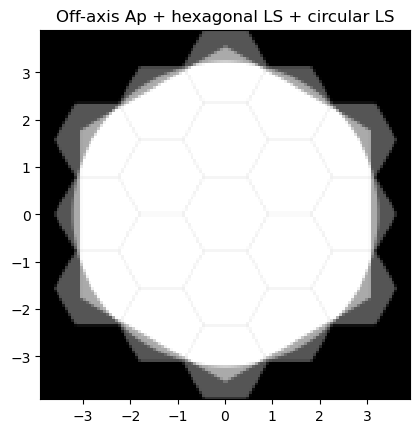

In [20]:
plt.title('Off-axis Ap + hexagonal LS + circular LS')
hcipy.imshow_field(lyot_stop_hex + lyot_stop_circ + pupil_offaxis, cmap='gray')

[Back to Parameters](#params)

[Top of page](#top)